# Planner Tutorial

This notebook teaches you how to build and use planners in the Simple Autonomous Car SDK.

## What You'll Learn

1. Understanding planners and their role
2. Using built-in planners (TrackPlanner)
3. Building custom planners
4. Integrating planners with costmaps and perception data
5. Visualizing plans

## What is a Planner?

A planner generates a path (sequence of waypoints) for the car to follow. Planners can use:
- **Map data**: Track boundaries, centerlines
- **Perception data**: Raw sensor measurements
- **Costmaps**: Processed obstacle representation
- **Goals**: Target destinations

The plan is then used by controllers to compute control commands.

In [1]:
import sys
sys.path.insert(0, '../../src')

import numpy as np
import matplotlib.pyplot as plt
from simple_autonomous_car import (
    Track,
    Car,
    CarState,
    GroundTruthMap,
    PerceivedMap,
    LiDARSensor,
    TrackPlanner,
    GridCostmap,
)
from simple_autonomous_car.visualization import (
    plot_car,
    plot_perception,
)

/home/wardn/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Step 1: Setup - Create Track, Car, and Sensors

In [2]:
# Create track
track = Track.create_simple_track(length=80.0, width=40.0, track_width=5.0)

# Create car
start_point, start_heading = track.get_point_at_distance(0.0)
car = Car(initial_state=CarState(x=start_point[0], y=start_point[1], heading=start_heading, velocity=8.0))

# Create maps and sensor
ground_truth_map = GroundTruthMap(track)
perceived_map = PerceivedMap(ground_truth_map)
lidar = LiDARSensor(ground_truth_map, perceived_map, max_range=40.0, name="lidar")
car.add_sensor(lidar)

# Create costmap
costmap = GridCostmap(width=60.0, height=60.0, resolution=0.5, inflation_radius=2.0, frame="ego")

print(f"✓ Setup complete")
print(f"  Track: {len(track.centerline)} points")
print(f"  Car at: ({car.state.x:.2f}, {car.state.y:.2f})")
print(f"  Sensors: {len(car.sensors)}")

✓ Setup complete
  Track: 400 points
  Car at: (-28.00, -20.00)
  Sensors: 1


## Step 2: Using TrackPlanner

In [3]:
# Create planner
planner = TrackPlanner(
    track=track,
    lookahead_distance=50.0,  # Plan 50m ahead
    waypoint_spacing=2.0,     # Waypoints every 2m
)

print(f"✓ Planner created")
print(f"  Lookahead: {planner.lookahead_distance}m")
print(f"  Waypoint spacing: {planner.waypoint_spacing}m")

✓ Planner created
  Lookahead: 50.0m
  Waypoint spacing: 2.0m


In [4]:
# Generate plan
plan = planner.plan(car.state)

print(f"✓ Generated plan with {len(plan)} waypoints")
print(f"  First waypoint: ({plan[0][0]:.2f}, {plan[0][1]:.2f})")
print(f"  Last waypoint: ({plan[-1][0]:.2f}, {plan[-1][1]:.2f})")

✓ Generated plan with 26 waypoints
  First waypoint: (-28.00, -20.00)
  Last waypoint: (22.00, -20.00)


## Step 3: Visualizing Plans

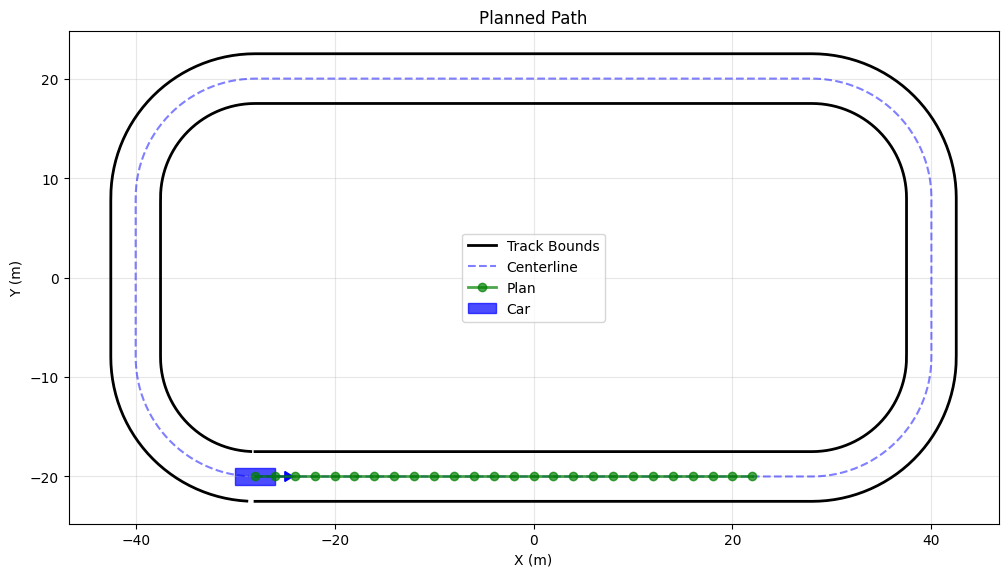

In [5]:
# Visualize plan
from simple_autonomous_car.visualization import plot_car

fig, ax = plt.subplots(figsize=(12, 10))
track.visualize(ax=ax, frame="global")
planner.visualize(ax=ax, car_state=car.state, plan=plan, frame="global", color="green", label="Plan", show_waypoints=True)
plot_car(car, ax=ax, show_heading=True)
plt.title("Planned Path")
plt.legend()
plt.show()

## Step 4: Planner with Perception Data

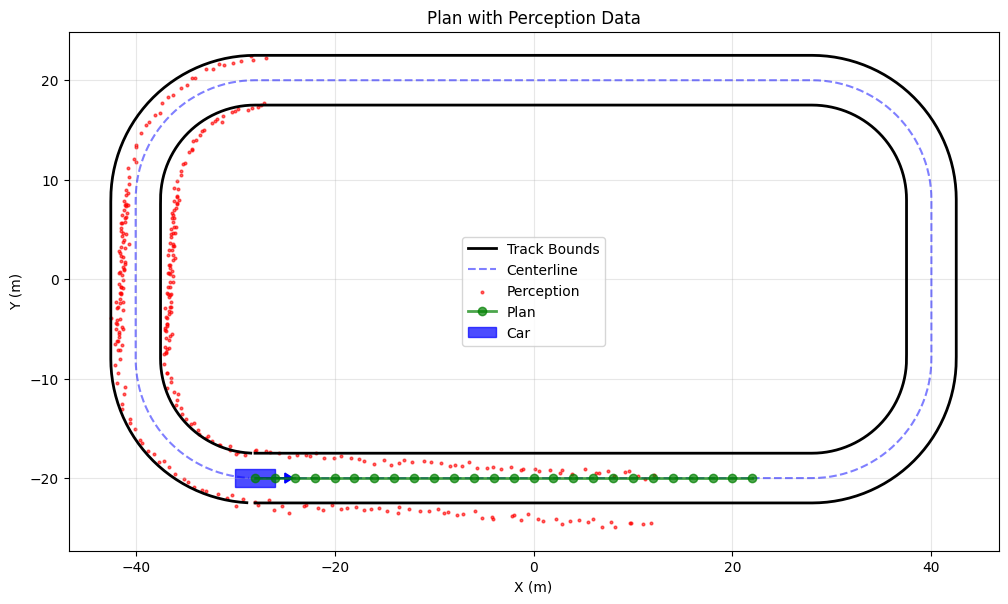

In [6]:
# Get perception data
perception_data = car.sense_all(environment_data={"ground_truth_map": ground_truth_map})

# Generate plan with perception data (planner can use it for obstacle avoidance)
plan_with_perception = planner.plan(
    car.state,
    perception_data=perception_data,
)

# Visualize
from simple_autonomous_car.visualization import plot_perception, plot_car

fig, ax = plt.subplots(figsize=(12, 10))
track.visualize(ax=ax, frame="global")
plot_perception(perception_data["lidar"], car.state, ax=ax, frame="global")
planner.visualize(ax=ax, car_state=car.state, plan=plan_with_perception, frame="global", color="green", label="Plan")
plot_car(car, ax=ax)
plt.title("Plan with Perception Data")
plt.legend()
plt.show()

## Step 5: Planner with Costmap

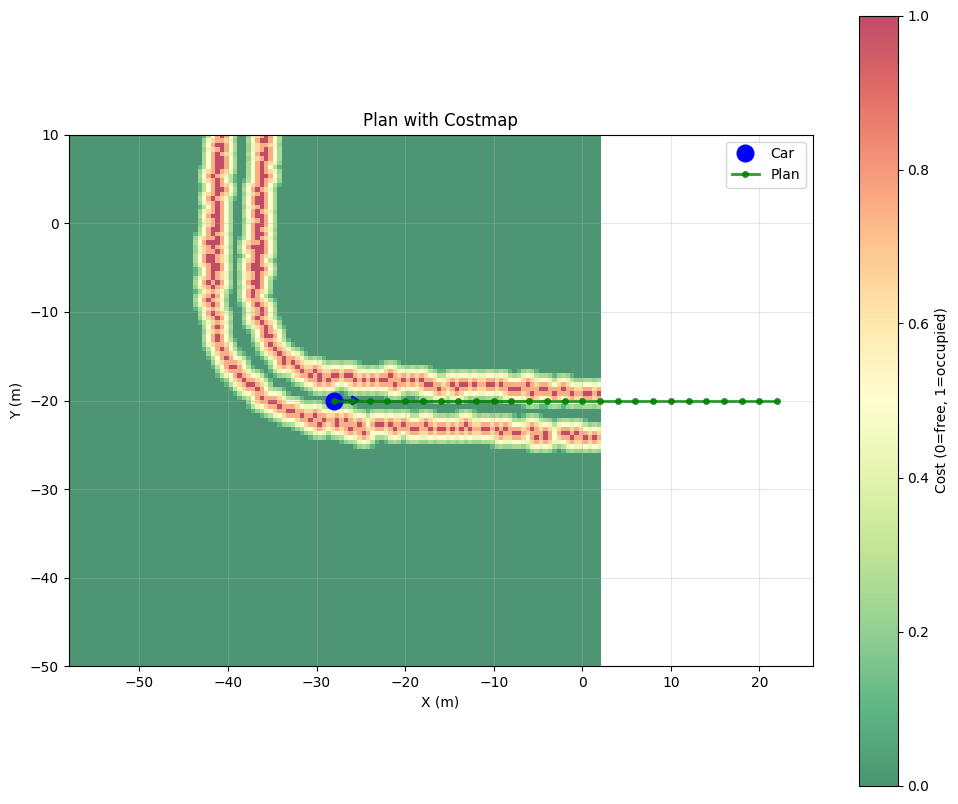

In [7]:
# Update costmap
costmap.update(perception_data, car.state)

# Generate plan with costmap (planner can avoid high-cost areas)
plan_with_costmap = planner.plan(
    car.state,
    perception_data=perception_data,
    costmap=costmap,
)

# Visualize
from simple_autonomous_car.visualization import plot_car

fig, ax = plt.subplots(figsize=(12, 10))
track.visualize(ax=ax, frame="global")
costmap.visualize(ax=ax, car_state=car.state, frame="global", alpha=0.3)
planner.visualize(ax=ax, car_state=car.state, plan=plan_with_costmap, frame="global", color="green", label="Plan")
plot_car(car, ax=ax, show_heading=True)
plt.title("Plan with Costmap")
plt.legend()
plt.show()

## Step 6: Building a Custom Planner

In [8]:
from simple_autonomous_car.planning.base_planner import BasePlanner

class MyCustomPlanner(BasePlanner):
    """
    Example custom planner.

    This shows how to build your own planner by extending BasePlanner.
    """

    def __init__(self, track, lookahead=30.0, name="custom_planner"):
        super().__init__(name=name)
        self.track = track
        self.lookahead = lookahead

    def plan(
        self,
        car_state,
        perception_data=None,
        costmap=None,
        goal=None,
    ) -> np.ndarray:
        """
        Your custom planning logic here!

        You can use:
        - perception_data: Raw sensor data
        - costmap: Processed obstacle representation
        - goal: Target destination
        """
        if not self.enabled:
            return np.array([]).reshape(0, 2)

        # Example: Simple planner that follows centerline but avoids high-cost areas
        car_pos = car_state.position()

        # Find closest point on centerline
        distances = np.linalg.norm(self.track.centerline - car_pos, axis=1)
        closest_idx = np.argmin(distances)

        # Generate waypoints ahead
        waypoints = []
        num_waypoints = int(self.lookahead / 2.0) + 1

        for i in range(num_waypoints):
            idx = (closest_idx + i * 2) % len(self.track.centerline)
            waypoint = self.track.centerline[idx].copy()

            # Adjust waypoint if costmap shows high cost
            if costmap is not None and costmap.is_enabled():
                cost = costmap.get_cost(waypoint, frame="global", car_state=car_state)
                if cost > 0.5:
                    # Move waypoint away from obstacle (simple heuristic)
                    direction = waypoint - car_pos
                    direction = direction / (np.linalg.norm(direction) + 1e-6)
                    waypoint = waypoint + 2.0 * direction  # Move 2m away

            waypoints.append(waypoint)

        return np.array(waypoints)

# Test custom planner
custom_planner = MyCustomPlanner(track, lookahead=40.0)
custom_plan = custom_planner.plan(car.state, perception_data=perception_data, costmap=costmap)

print(f"✓ Custom planner created and tested!")
print(f"  Generated {len(custom_plan)} waypoints")

✓ Custom planner created and tested!
  Generated 21 waypoints


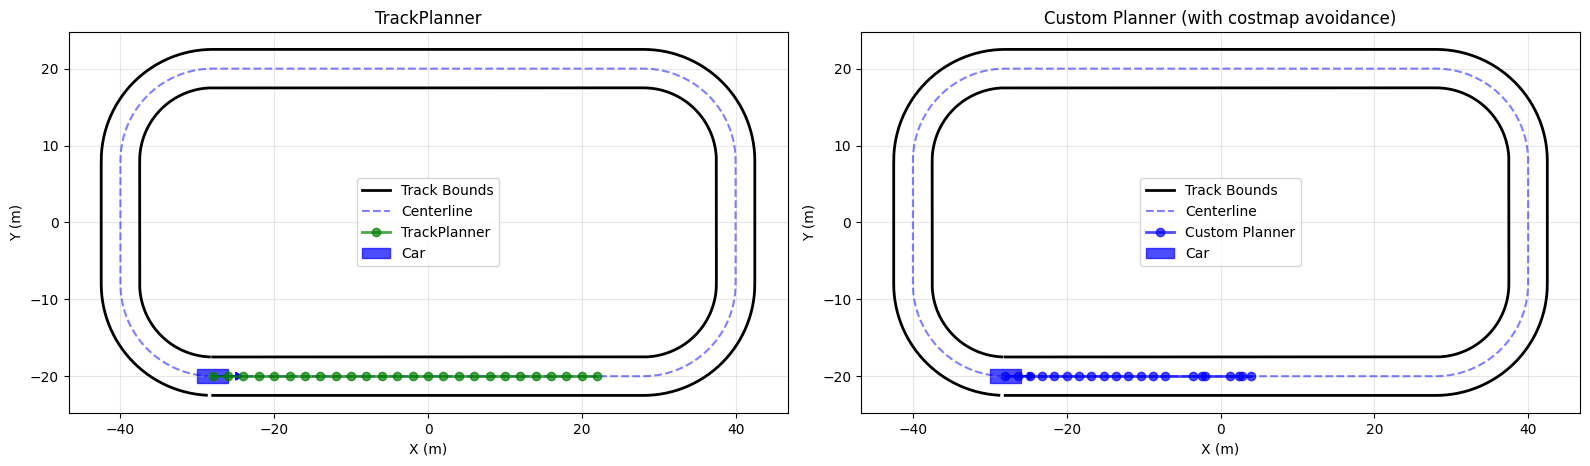

In [9]:
# Compare plans
from simple_autonomous_car.visualization import plot_car

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# TrackPlanner
track.visualize(ax=axes[0], frame="global")
planner.visualize(ax=axes[0], car_state=car.state, plan=plan_with_costmap, frame="global", color="green", label="TrackPlanner")
plot_car(car, ax=axes[0])
axes[0].set_title("TrackPlanner")
axes[0].legend()

# Custom planner
track.visualize(ax=axes[1], frame="global")
# Note: custom_planner should also have a visualize() method if it's a BasePlanner subclass
# For now, we'll plot it manually if needed
if hasattr(custom_planner, 'visualize'):
    custom_planner.visualize(ax=axes[1], car_state=car.state, plan=custom_plan, frame="global", color="blue", label="Custom Planner")
else:
    axes[1].plot(custom_plan[:, 0], custom_plan[:, 1], "b-", linewidth=2.5, label="Custom Planner")
plot_car(car, ax=axes[1])
axes[1].set_title("Custom Planner (with costmap avoidance)")
axes[1].legend()

plt.tight_layout()
plt.show()

## Step 7: Planner Parameters

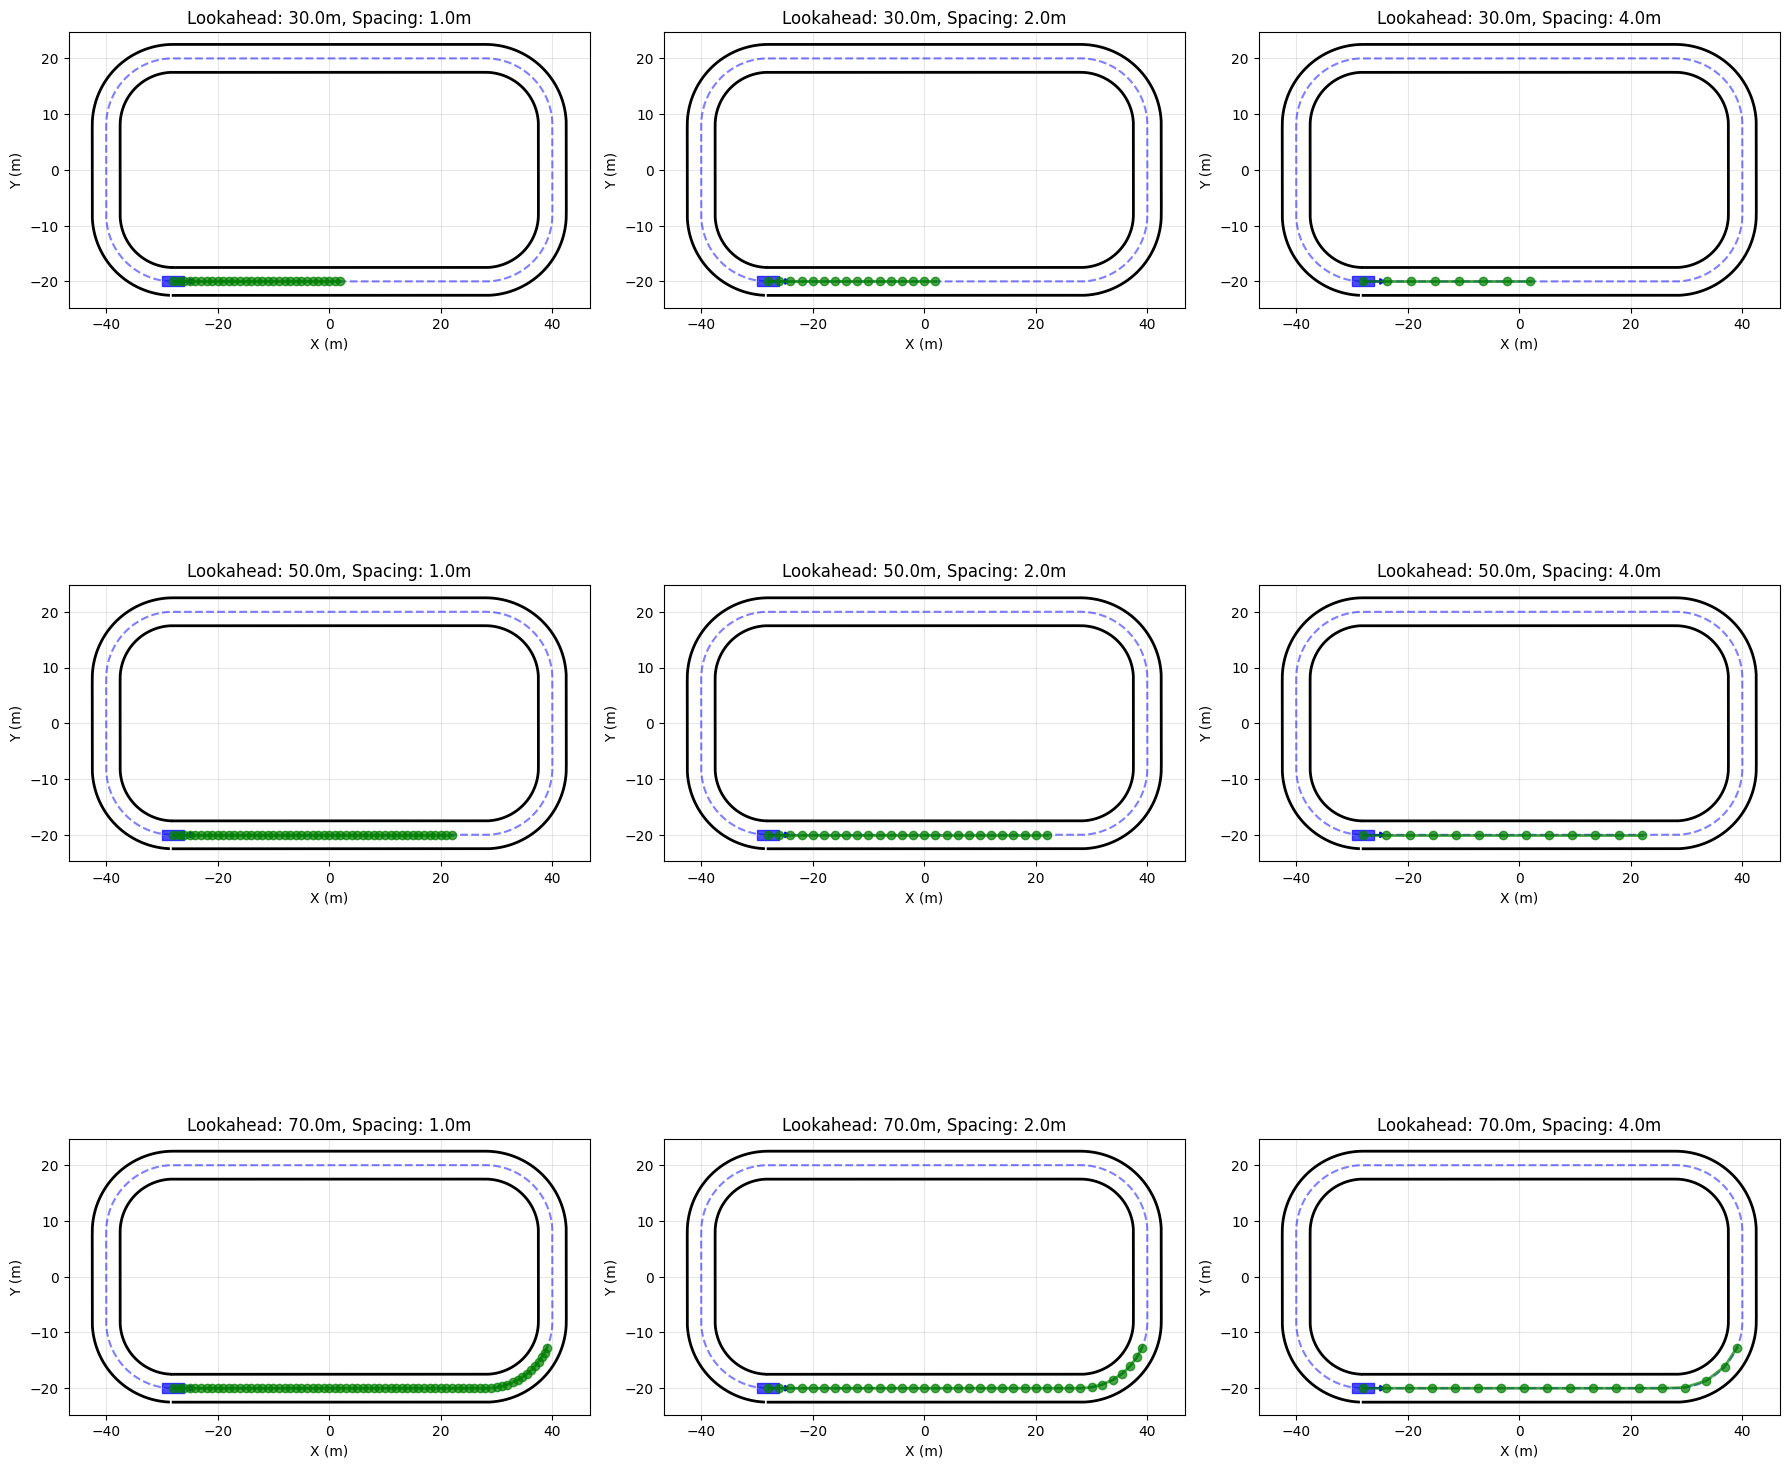


Notice how parameters affect the plan:
  - Larger lookahead = plan extends further ahead
  - Smaller spacing = more waypoints (smoother but more computation)


In [10]:
# Compare different planner parameters
lookaheads = [30.0, 50.0, 70.0]
spacings = [1.0, 2.0, 4.0]

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for i, lookahead in enumerate(lookaheads):
    for j, spacing in enumerate(spacings):
        test_planner = TrackPlanner(track, lookahead_distance=lookahead, waypoint_spacing=spacing)
        test_plan = test_planner.plan(car.state)

        plot_track(track, ax=axes[i, j])
        plot_plan(test_plan, ax=axes[i, j], color="green", show_waypoints=True)
        plot_car(car, ax=axes[i, j])
        axes[i, j].set_title(f"Lookahead: {lookahead}m, Spacing: {spacing}m")

plt.tight_layout()
plt.show()

print("\nNotice how parameters affect the plan:")
print("  - Larger lookahead = plan extends further ahead")
print("  - Smaller spacing = more waypoints (smoother but more computation)")

## Step 8: Complete Example - Planner in Control Loop

In [11]:
from simple_autonomous_car import PurePursuitController

# Setup
planner = TrackPlanner(track, lookahead_distance=50.0, waypoint_spacing=2.0)
controller = PurePursuitController(lookahead_distance=10.0, target_velocity=8.0)

# Simulation loop
dt = 0.1
num_steps = 100
trajectory = []
plans_history = []

for step in range(num_steps):
    # 1. Get perception
    perception_data = car.sense_all(environment_data={"ground_truth_map": ground_truth_map})

    # 2. Update costmap
    costmap.update(perception_data, car.state)

    # 3. Generate plan (planner uses perception and costmap)
    plan = planner.plan(car.state, perception_data=perception_data, costmap=costmap)
    plans_history.append(plan.copy() if len(plan) > 0 else None)

    # 4. Compute control
    control = controller.compute_control(
        car.state,
        perception_data=perception_data,
        costmap=costmap,
        plan=plan,
    )

    # 5. Update car
    car.update(dt, acceleration=control["acceleration"], steering_rate=control["steering_rate"])

    trajectory.append(car.state.position().copy())

print(f"✓ Simulation complete!")
print(f"  Steps: {num_steps}")
print(f"  Final position: ({car.state.x:.2f}, {car.state.y:.2f})")
print(f"  Final velocity: {car.state.velocity:.2f} m/s")

✓ Simulation complete!
  Steps: 100
  Final position: (38.00, -0.05)
  Final velocity: 6.48 m/s


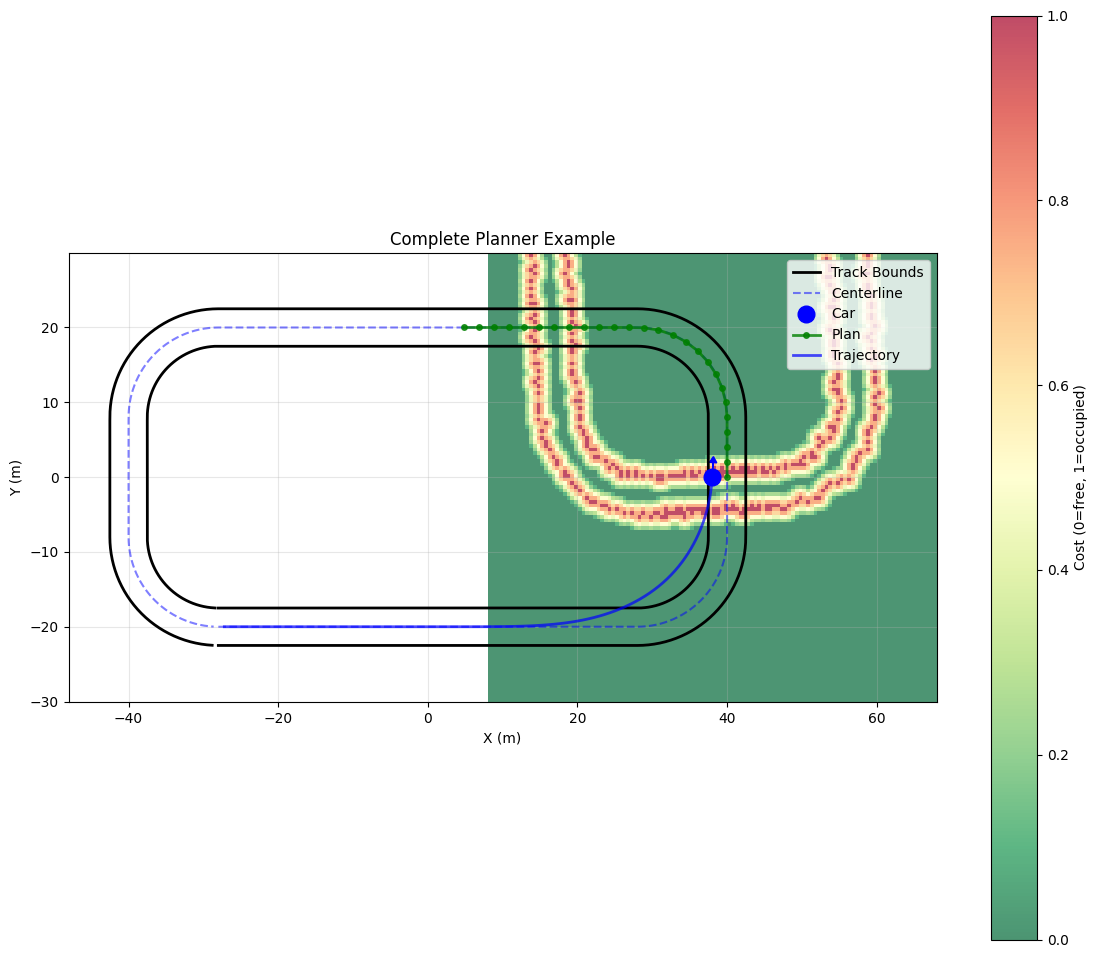

In [12]:
# Visualize final state
fig, ax = plt.subplots(figsize=(14, 12))

# Update one more time
perception_data = car.sense_all(environment_data={"ground_truth_map": ground_truth_map})
costmap.update(perception_data, car.state)
plan = planner.plan(car.state, perception_data=perception_data, costmap=costmap)

# Plot
from simple_autonomous_car.visualization import plot_car

track.visualize(ax=ax, frame="global")
costmap.visualize(ax=ax, car_state=car.state, frame="global", alpha=0.3)
planner.visualize(ax=ax, car_state=car.state, plan=plan, frame="global", color="green", label="Plan")
plot_car(car, ax=ax, show_heading=True)

# Plot trajectory
if len(trajectory) > 1:
    traj_array = np.array(trajectory)
    ax.plot(traj_array[:, 0], traj_array[:, 1], 'b-', linewidth=2, alpha=0.7, label='Trajectory')

plt.title("Complete Planner Example")
plt.legend()
plt.show()

## Summary

You've learned:

1. ✅ **Using planners**: TrackPlanner for basic path following
2. ✅ **Planner parameters**: Lookahead distance and waypoint spacing
3. ✅ **Integration**: Using perception data and costmaps
4. ✅ **Building custom planners**: Extend BasePlanner for your needs
5. ✅ **Visualization**: Plot plans and compare different planners
6. ✅ **Control loop**: Planner → Controller → Car

### Key Concepts

- **Planners generate paths**: Sequence of waypoints to follow
- **Multiple data sources**: Can use map, perception, and costmap
- **Modular design**: Easy to build custom planners
- **Integration**: Works seamlessly with controllers

### Next Steps

- Build A* or RRT planners for obstacle avoidance
- Build dynamic planners that react to perception
- Combine multiple planners
- Optimize plans based on costmaps